In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageStat
import pandas as pd
from collections import defaultdict
import random
from skimage import feature, measure, filters
from scipy import ndimage
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 설정
TEST_DATA_PATH = '../../input/data/test'
SAMPLE_SIZE = 50  # 분석할 샘플 이미지 수
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [11]:
# 이미지 파일 목록 가져오기
def get_image_files(path):
    """테스트 폴더에서 이미지 파일들을 가져옵니다."""
    image_files = []
    for file in os.listdir(path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_files.append(os.path.join(path, file))
    return image_files

# 이미지 파일 목록 생성
image_files = get_image_files(TEST_DATA_PATH)
print(f"총 이미지 파일 수: {len(image_files)}")

# 랜덤하게 샘플 선택
random.seed(42)
sample_files = random.sample(image_files, min(SAMPLE_SIZE, len(image_files)))
print(f"분석할 샘플 수: {len(sample_files)}")

# 첫 몇 개 파일명 출력
print("\n샘플 파일들:")
for i, file in enumerate(sample_files[:10]):
    print(f"{i+1}: {os.path.basename(file)}")


총 이미지 파일 수: 3140
분석할 샘플 수: 50

샘플 파일들:
1: c34da2a0905551f7.jpg
2: 08590b0bed418283.jpg
3: bc41bdc300fbe45a.jpg
4: b7684f2d88132a50.jpg
5: 2e75bf13e029c0a9.jpg
6: f0231abdaf73d007.jpg
7: 45fa31f65f2a2944.jpg
8: 09eb83058248f2ac.jpg
9: 2e51d14abe1a4fd9.jpg
10: 3efe84af55458358.jpg


In [12]:
# 이미지 분석 함수들
def analyze_image_properties(image_path):
    """이미지의 기본 속성들을 분석합니다."""
    # PIL로 이미지 로드
    pil_img = Image.open(image_path)
    
    # OpenCV로 이미지 로드
    cv_img = cv2.imread(image_path)
    cv_img_rgb = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    
    properties = {
        'filename': os.path.basename(image_path),
        'size': pil_img.size,
        'width': pil_img.size[0],
        'height': pil_img.size[1],
        'aspect_ratio': pil_img.size[0] / pil_img.size[1],
        'mode': pil_img.mode,
        'format': pil_img.format
    }
    
    # 색상 통계
    if cv_img is not None:
        # 밝기 통계
        gray = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)
        properties['mean_brightness'] = np.mean(gray)
        properties['std_brightness'] = np.std(gray)
        
        # 색상 채널별 통계
        b_mean, g_mean, r_mean = np.mean(cv_img, axis=(0,1))
        properties['mean_blue'] = b_mean
        properties['mean_green'] = g_mean
        properties['mean_red'] = r_mean
        
        # 대비 계산 (표준편차 기반)
        properties['contrast'] = np.std(gray)
        
        # 엣지 강도 (Sobel)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        edge_strength = np.sqrt(sobelx**2 + sobely**2)
        properties['edge_strength'] = np.mean(edge_strength)
        
    return properties, cv_img_rgb

# 샘플 이미지들 분석
print("이미지들을 분석 중...")
image_data = []
sample_images = []

for i, img_path in enumerate(sample_files):
    try:
        props, img = analyze_image_properties(img_path)
        image_data.append(props)
        sample_images.append(img)
        
        if (i + 1) % 10 == 0:
            print(f"진행률: {i+1}/{len(sample_files)}")
    except Exception as e:
        print(f"오류 발생 {img_path}: {e}")

# 데이터프레임으로 변환
df = pd.DataFrame(image_data)
print(f"\n분석 완료! 총 {len(df)}개 이미지 분석됨")
print("\n기본 통계:")
print(df.describe())


이미지들을 분석 중...
진행률: 10/50
진행률: 20/50
진행률: 30/50
진행률: 40/50
진행률: 50/50

분석 완료! 총 50개 이미지 분석됨

기본 통계:
            width      height  aspect_ratio  mean_brightness  std_brightness  \
count   50.000000   50.000000     50.000000        50.000000       50.000000   
mean   517.540000  518.680000      1.048516       179.271636       45.749413   
std     82.347747   82.492904      0.327863        33.612847       21.799722   
min    384.000000  383.000000      0.563050        96.788131       24.308062   
25%    443.000000  443.000000      0.749577       157.198725       29.789312   
50%    517.000000  517.000000      1.041831       194.313890       37.125141   
75%    591.000000  591.000000      1.334086       205.346976       53.741683   
max    682.000000  682.000000      1.780679       220.160848      111.112004   

        mean_blue  mean_green    mean_red    contrast  edge_strength  
count   50.000000   50.000000   50.000000   50.000000      50.000000  
mean   180.606235  179.741133  177.906

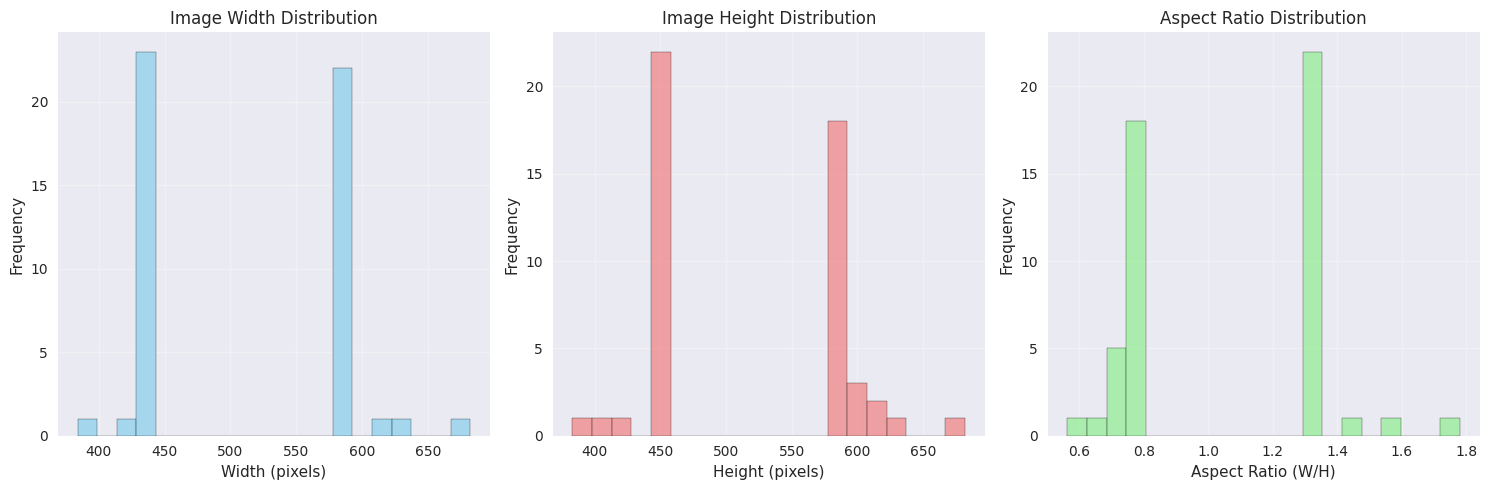

=== 이미지 크기 분석 ===
너비 범위: 384 ~ 682
높이 범위: 383 ~ 682
종횡비 범위: 0.563 ~ 1.781
고유한 크기의 수: 12
✅ 크기 조정 증강이 적용된 것으로 보입니다.


In [13]:
# 1. 이미지 크기 분석 (크기 조정/크롭핑 증강 탐지)
plt.figure(figsize=(15, 5))

# 이미지 너비 분포
plt.subplot(1, 3, 1)
plt.hist(df['width'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 이미지 높이 분포
plt.subplot(1, 3, 2)
plt.hist(df['height'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 종횡비 분포
plt.subplot(1, 3, 3)
plt.hist(df['aspect_ratio'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (W/H)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 크기 통계 출력
print("=== 이미지 크기 분석 ===")
print(f"너비 범위: {df['width'].min()} ~ {df['width'].max()}")
print(f"높이 범위: {df['height'].min()} ~ {df['height'].max()}")
print(f"종횡비 범위: {df['aspect_ratio'].min():.3f} ~ {df['aspect_ratio'].max():.3f}")
print(f"고유한 크기의 수: {len(df[['width', 'height']].drop_duplicates())}")

# 크기 조정 증강 가능성 분석
if len(df[['width', 'height']].drop_duplicates()) > 1:
    print("✅ 크기 조정 증강이 적용된 것으로 보입니다.")
else:
    print("❌ 모든 이미지가 동일한 크기입니다.")


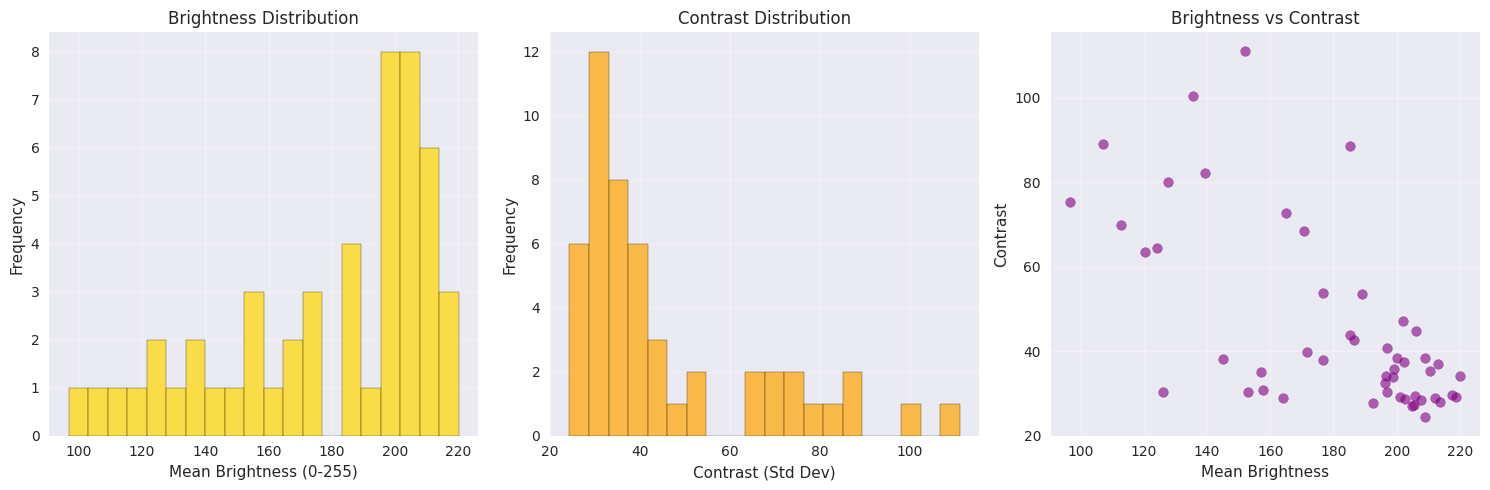

=== 밝기 및 대비 분석 ===
밝기 범위: 96.79 ~ 220.16
대비 범위: 24.31 ~ 111.11
밝기 표준편차: 33.61
대비 표준편차: 21.80
✅ 밝기 조정 증강이 적용된 것으로 보입니다.
✅ 대비 조정 증강이 적용된 것으로 보입니다.


In [14]:
# 2. 밝기 및 대비 분석 (밝기/대비 증강 탐지)
plt.figure(figsize=(15, 5))

# 밝기 분포
plt.subplot(1, 3, 1)
plt.hist(df['mean_brightness'], bins=20, alpha=0.7, color='gold', edgecolor='black')
plt.title('Brightness Distribution')
plt.xlabel('Mean Brightness (0-255)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 대비 분포
plt.subplot(1, 3, 2)
plt.hist(df['contrast'], bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Contrast Distribution')
plt.xlabel('Contrast (Std Dev)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 밝기 vs 대비 산점도
plt.subplot(1, 3, 3)
plt.scatter(df['mean_brightness'], df['contrast'], alpha=0.6, color='purple')
plt.title('Brightness vs Contrast')
plt.xlabel('Mean Brightness')
plt.ylabel('Contrast')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 밝기/대비 통계 출력
print("=== 밝기 및 대비 분석 ===")
print(f"밝기 범위: {df['mean_brightness'].min():.2f} ~ {df['mean_brightness'].max():.2f}")
print(f"대비 범위: {df['contrast'].min():.2f} ~ {df['contrast'].max():.2f}")
print(f"밝기 표준편차: {df['mean_brightness'].std():.2f}")
print(f"대비 표준편차: {df['contrast'].std():.2f}")

# 밝기/대비 증강 가능성 분석
brightness_cv = df['mean_brightness'].std() / df['mean_brightness'].mean()
contrast_cv = df['contrast'].std() / df['contrast'].mean()

if brightness_cv > 0.15:
    print("✅ 밝기 조정 증강이 적용된 것으로 보입니다.")
else:
    print("❌ 밝기가 일관됩니다.")

if contrast_cv > 0.15:
    print("✅ 대비 조정 증강이 적용된 것으로 보입니다.")
else:
    print("❌ 대비가 일관됩니다.")


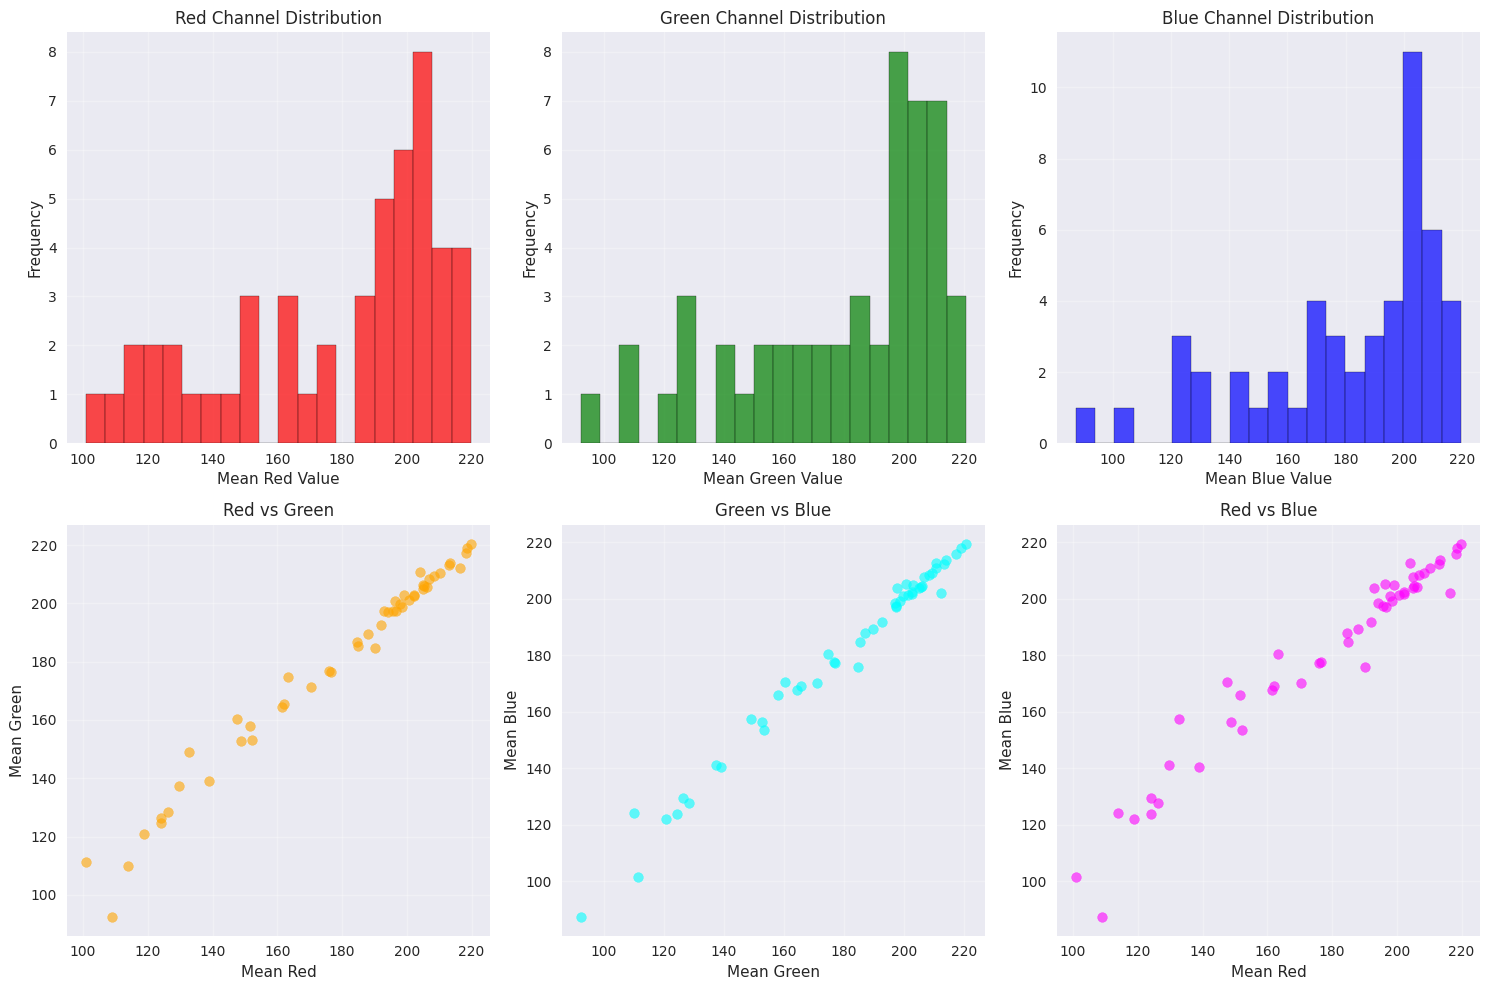

=== 색상 분석 ===
빨간색 범위: 100.94 ~ 219.75
초록색 범위: 92.37 ~ 220.54
파란색 범위: 87.29 ~ 219.62
빨간색 변이계수: 0.192
초록색 변이계수: 0.187
파란색 변이계수: 0.183
✅ 색상 조정 증강이 적용된 것으로 보입니다.


In [15]:
# 3. 색상 분석 (색상 조정 증강 탐지)
plt.figure(figsize=(15, 10))

# RGB 채널별 분포
plt.subplot(2, 3, 1)
plt.hist(df['mean_red'], bins=20, alpha=0.7, color='red', edgecolor='black')
plt.title('Red Channel Distribution')
plt.xlabel('Mean Red Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.hist(df['mean_green'], bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Green Channel Distribution')
plt.xlabel('Mean Green Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
plt.hist(df['mean_blue'], bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Blue Channel Distribution')
plt.xlabel('Mean Blue Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# RGB 채널 간 관계
plt.subplot(2, 3, 4)
plt.scatter(df['mean_red'], df['mean_green'], alpha=0.6, color='orange')
plt.title('Red vs Green')
plt.xlabel('Mean Red')
plt.ylabel('Mean Green')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
plt.scatter(df['mean_green'], df['mean_blue'], alpha=0.6, color='cyan')
plt.title('Green vs Blue')
plt.xlabel('Mean Green')
plt.ylabel('Mean Blue')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
plt.scatter(df['mean_red'], df['mean_blue'], alpha=0.6, color='magenta')
plt.title('Red vs Blue')
plt.xlabel('Mean Red')
plt.ylabel('Mean Blue')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 색상 통계 출력
print("=== 색상 분석 ===")
print(f"빨간색 범위: {df['mean_red'].min():.2f} ~ {df['mean_red'].max():.2f}")
print(f"초록색 범위: {df['mean_green'].min():.2f} ~ {df['mean_green'].max():.2f}")
print(f"파란색 범위: {df['mean_blue'].min():.2f} ~ {df['mean_blue'].max():.2f}")

# 색상 증강 가능성 분석
red_cv = df['mean_red'].std() / df['mean_red'].mean()
green_cv = df['mean_green'].std() / df['mean_green'].mean()
blue_cv = df['mean_blue'].std() / df['mean_blue'].mean()

print(f"빨간색 변이계수: {red_cv:.3f}")
print(f"초록색 변이계수: {green_cv:.3f}")
print(f"파란색 변이계수: {blue_cv:.3f}")

if max(red_cv, green_cv, blue_cv) > 0.15:
    print("✅ 색상 조정 증강이 적용된 것으로 보입니다.")
else:
    print("❌ 색상이 일관됩니다.")


회전 특징을 분석 중...
회전 분석 진행률: 5/20
회전 분석 진행률: 10/20
회전 분석 진행률: 15/20
회전 분석 진행률: 20/20


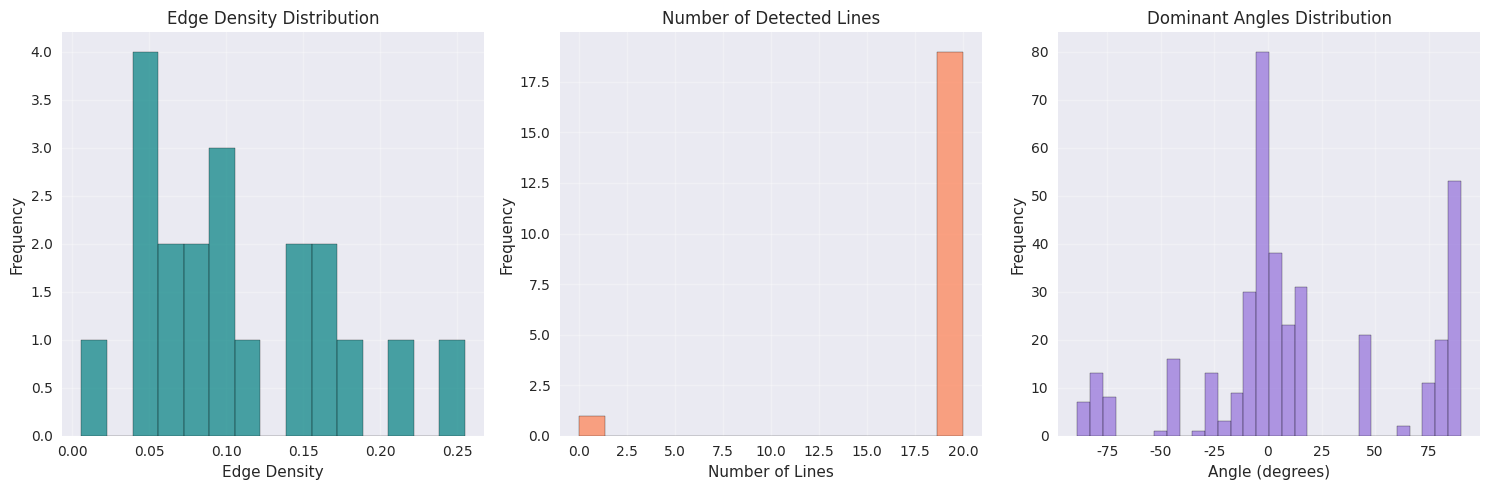

=== 회전 분석 ===
검출된 주요 각도 수: 380
각도 범위: -89.0° ~ 90.0°
각도 표준편차: 47.05°
수직/수평선: 253개
대각선: 127개
✅ 회전 증강이 적용된 것으로 보입니다.


In [16]:
# 4. 회전 분석 (회전 증강 탐지)
def detect_rotation_features(image):
    """이미지에서 회전 관련 특징을 추출합니다."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    # 엣지 검출
    edges = cv2.Canny(gray, 50, 150)
    
    # Hough 변환으로 직선 검출
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=100)
    
    angles = []
    if lines is not None and len(lines) > 0:
        # lines의 차원을 확인하고 적절히 처리
        if len(lines.shape) == 3:
            # 3차원 배열인 경우 [[[rho, theta]], ...] -> [[rho, theta], ...]
            lines = lines[:, 0, :]
        
        # 상위 20개 직선만 사용
        for line_data in lines[:20]:
            if len(line_data) >= 2:  # 안전성 체크
                rho, theta = line_data[0], line_data[1]
                angle = np.degrees(theta)
                # 각도를 -90~90 범위로 정규화
                if angle > 90:
                    angle -= 180
                angles.append(angle)
    
    return {
        'dominant_angles': angles,
        'num_lines': len(angles) if angles else 0,
        'angle_std': np.std(angles) if angles else 0,
        'edge_density': np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
    }

# 회전 특징 분석
print("회전 특징을 분석 중...")
rotation_features = []

for i, img in enumerate(sample_images[:20]):  # 처리 시간을 위해 20개만 분석
    if img is not None:
        features = detect_rotation_features(img)
        features['filename'] = df.iloc[i]['filename']
        rotation_features.append(features)
    
    if (i + 1) % 5 == 0:
        print(f"회전 분석 진행률: {i+1}/20")

# 회전 특징 시각화
plt.figure(figsize=(15, 5))

# 엣지 밀도 분포
plt.subplot(1, 3, 1)
edge_densities = [f['edge_density'] for f in rotation_features]
plt.hist(edge_densities, bins=15, alpha=0.7, color='teal', edgecolor='black')
plt.title('Edge Density Distribution')
plt.xlabel('Edge Density')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 검출된 직선 수 분포
plt.subplot(1, 3, 2)
num_lines = [f['num_lines'] for f in rotation_features]
plt.hist(num_lines, bins=15, alpha=0.7, color='coral', edgecolor='black')
plt.title('Number of Detected Lines')
plt.xlabel('Number of Lines')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 각도 분포 (모든 각도)
plt.subplot(1, 3, 3)
all_angles = []
for f in rotation_features:
    all_angles.extend(f['dominant_angles'])

if all_angles:
    plt.hist(all_angles, bins=30, alpha=0.7, color='mediumpurple', edgecolor='black')
    plt.title('Dominant Angles Distribution')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 회전 분석 결과
print("=== 회전 분석 ===")
if all_angles:
    print(f"검출된 주요 각도 수: {len(all_angles)}")
    print(f"각도 범위: {min(all_angles):.1f}° ~ {max(all_angles):.1f}°")
    print(f"각도 표준편차: {np.std(all_angles):.2f}°")
    
    # 수직/수평선 비율
    vertical_horizontal = sum(1 for angle in all_angles if abs(angle) < 10 or abs(angle) > 80)
    diagonal = len(all_angles) - vertical_horizontal
    
    print(f"수직/수평선: {vertical_horizontal}개")
    print(f"대각선: {diagonal}개")
    
    if diagonal > vertical_horizontal * 0.3:
        print("✅ 회전 증강이 적용된 것으로 보입니다.")
    else:
        print("❌ 회전 증강의 명확한 증거가 없습니다.")
else:
    print("❌ 직선을 충분히 검출하지 못했습니다.")


대칭성을 분석 중...
대칭성 분석 진행률: 5/25
대칭성 분석 진행률: 10/25
대칭성 분석 진행률: 15/25
대칭성 분석 진행률: 20/25
대칭성 분석 진행률: 25/25


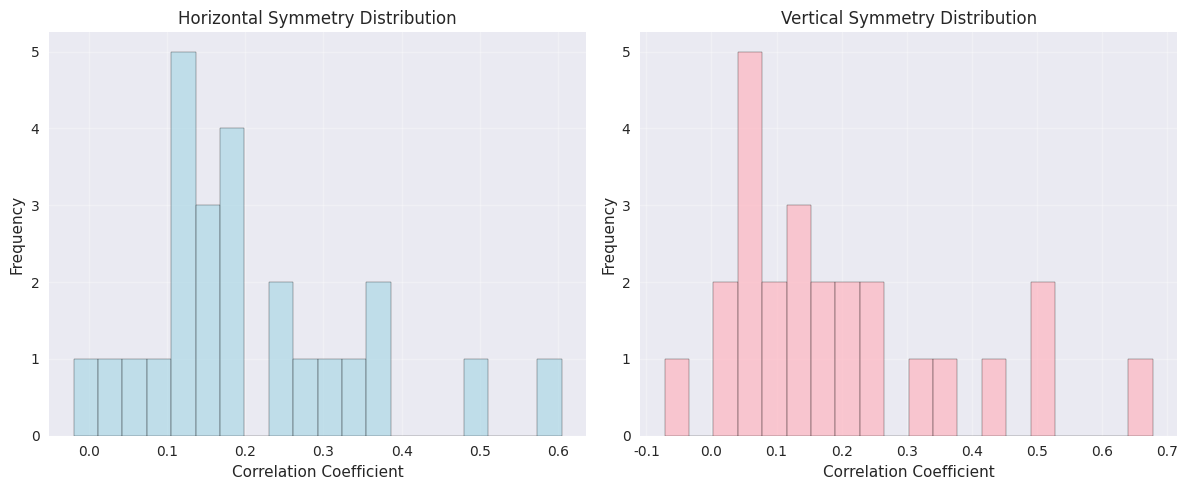

=== 플리핑 분석 ===
좌우 대칭성 평균: 0.211
상하 대칭성 평균: 0.196
좌우 대칭성 표준편차: 0.141
상하 대칭성 표준편차: 0.180
높은 좌우 대칭성 이미지: 0개
높은 상하 대칭성 이미지: 0개
✅ 플리핑 증강이 적용되었을 가능성이 있습니다.


In [17]:
# 5. 플리핑 분석 (좌우/상하 대칭성 분석)
def analyze_symmetry(image):
    """이미지의 대칭성을 분석합니다."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    h, w = gray.shape
    
    # 좌우 대칭성 분석
    left_half = gray[:, :w//2]
    right_half = gray[:, w//2:]
    right_half_flipped = np.fliplr(right_half)
    
    # 크기를 맞춤
    min_width = min(left_half.shape[1], right_half_flipped.shape[1])
    left_half = left_half[:, :min_width]
    right_half_flipped = right_half_flipped[:, :min_width]
    
    # 좌우 대칭성 계산 (구조 유사도)
    horizontal_symmetry = np.corrcoef(left_half.flatten(), right_half_flipped.flatten())[0, 1]
    if np.isnan(horizontal_symmetry):
        horizontal_symmetry = 0
    
    # 상하 대칭성 분석
    top_half = gray[:h//2, :]
    bottom_half = gray[h//2:, :]
    bottom_half_flipped = np.flipud(bottom_half)
    
    # 크기를 맞춤
    min_height = min(top_half.shape[0], bottom_half_flipped.shape[0])
    top_half = top_half[:min_height, :]
    bottom_half_flipped = bottom_half_flipped[:min_height, :]
    
    # 상하 대칭성 계산
    vertical_symmetry = np.corrcoef(top_half.flatten(), bottom_half_flipped.flatten())[0, 1]
    if np.isnan(vertical_symmetry):
        vertical_symmetry = 0
    
    return {
        'horizontal_symmetry': horizontal_symmetry,
        'vertical_symmetry': vertical_symmetry
    }

# 대칭성 분석
print("대칭성을 분석 중...")
symmetry_data = []

for i, img in enumerate(sample_images[:25]):  # 25개 이미지 분석
    if img is not None:
        symmetry = analyze_symmetry(img)
        symmetry['filename'] = df.iloc[i]['filename']
        symmetry_data.append(symmetry)
    
    if (i + 1) % 5 == 0:
        print(f"대칭성 분석 진행률: {i+1}/25")

# 대칭성 시각화
plt.figure(figsize=(12, 5))

# 좌우 대칭성 분포
plt.subplot(1, 2, 1)
h_symmetries = [s['horizontal_symmetry'] for s in symmetry_data]
plt.hist(h_symmetries, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
plt.title('Horizontal Symmetry Distribution')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 상하 대칭성 분포
plt.subplot(1, 2, 2)
v_symmetries = [s['vertical_symmetry'] for s in symmetry_data]
plt.hist(v_symmetries, bins=20, alpha=0.7, color='lightpink', edgecolor='black')
plt.title('Vertical Symmetry Distribution')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 대칭성 분석 결과
print("=== 플리핑 분석 ===")
print(f"좌우 대칭성 평균: {np.mean(h_symmetries):.3f}")
print(f"상하 대칭성 평균: {np.mean(v_symmetries):.3f}")
print(f"좌우 대칭성 표준편차: {np.std(h_symmetries):.3f}")
print(f"상하 대칭성 표준편차: {np.std(v_symmetries):.3f}")

# 높은 대칭성을 가진 이미지들
high_h_symmetry = sum(1 for s in h_symmetries if s > 0.7)
high_v_symmetry = sum(1 for s in v_symmetries if s > 0.7)

print(f"높은 좌우 대칭성 이미지: {high_h_symmetry}개")
print(f"높은 상하 대칭성 이미지: {high_v_symmetry}개")

# 플리핑 증강 가능성
if np.std(h_symmetries) > 0.15 or np.std(v_symmetries) > 0.15:
    print("✅ 플리핑 증강이 적용되었을 가능성이 있습니다.")
else:
    print("❌ 플리핑 증강의 명확한 증거가 없습니다.")


노이즈 및 블러를 분석 중...
노이즈/블러 분석 진행률: 10/30
노이즈/블러 분석 진행률: 20/30
노이즈/블러 분석 진행률: 30/30


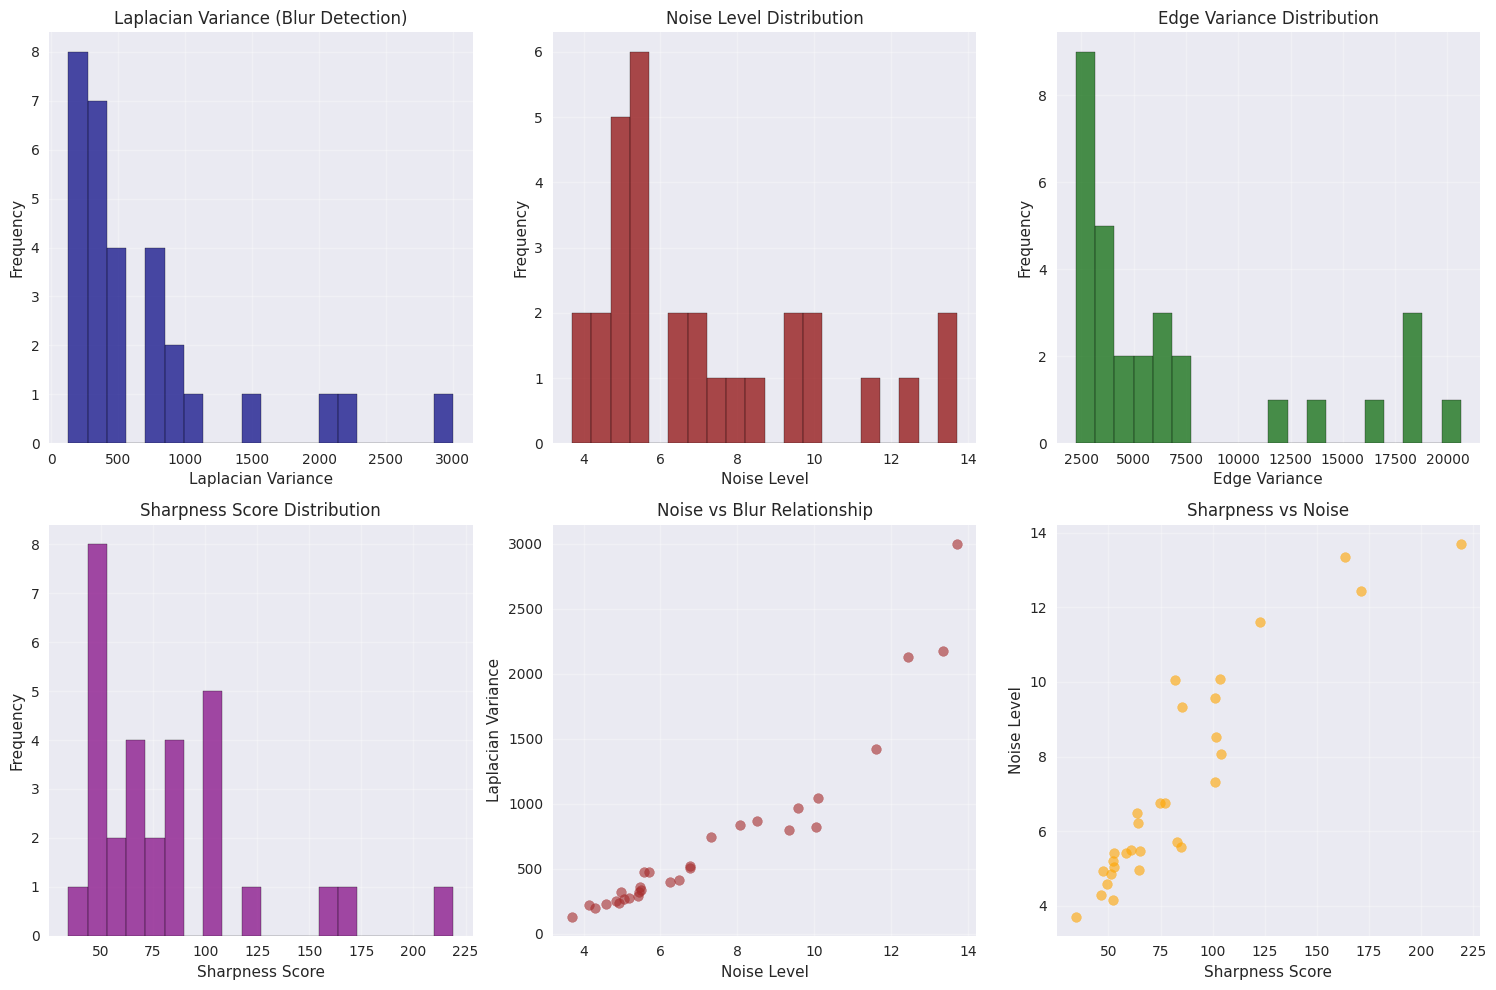

=== 노이즈 및 블러 분석 ===
라플라시안 분산 범위: 127.28 ~ 3002.97
노이즈 레벨 범위: 3.70 ~ 13.71
엣지 분산 범위: 2232.51 ~ 20638.97
블러 변이계수: 0.948
노이즈 변이계수: 0.391
✅ 블러 증강이 적용된 것으로 보입니다.
✅ 노이즈 추가 증강이 적용된 것으로 보입니다.


In [18]:
# 6. 노이즈 및 블러 분석
def analyze_noise_blur(image):
    """이미지의 노이즈와 블러를 분석합니다."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    # 라플라시안 분산 (블러 측정)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    
    # 고주파 성분 분석 (노이즈 측정)
    # 가우시안 필터링 후 차이 계산
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    high_freq = gray.astype(np.float64) - blurred.astype(np.float64)
    noise_level = np.std(high_freq)
    
    # 엣지 강도 분산 (선명도)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    edge_magnitude = np.sqrt(sobelx**2 + sobely**2)
    edge_variance = np.var(edge_magnitude)
    
    return {
        'laplacian_variance': laplacian_var,
        'noise_level': noise_level,
        'edge_variance': edge_variance,
        'sharpness_score': laplacian_var / (noise_level + 1e-6)  # 선명도 대 노이즈 비율
    }

# 노이즈/블러 분석
print("노이즈 및 블러를 분석 중...")
noise_blur_data = []

for i, img in enumerate(sample_images[:30]):  # 30개 이미지 분석
    if img is not None:
        analysis = analyze_noise_blur(img)
        analysis['filename'] = df.iloc[i]['filename']
        noise_blur_data.append(analysis)
    
    if (i + 1) % 10 == 0:
        print(f"노이즈/블러 분석 진행률: {i+1}/30")

# 노이즈/블러 시각화
plt.figure(figsize=(15, 10))

# 라플라시안 분산 (블러 측정)
plt.subplot(2, 3, 1)
laplacian_vars = [d['laplacian_variance'] for d in noise_blur_data]
plt.hist(laplacian_vars, bins=20, alpha=0.7, color='navy', edgecolor='black')
plt.title('Laplacian Variance (Blur Detection)')
plt.xlabel('Laplacian Variance')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 노이즈 레벨
plt.subplot(2, 3, 2)
noise_levels = [d['noise_level'] for d in noise_blur_data]
plt.hist(noise_levels, bins=20, alpha=0.7, color='darkred', edgecolor='black')
plt.title('Noise Level Distribution')
plt.xlabel('Noise Level')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 엣지 분산
plt.subplot(2, 3, 3)
edge_variances = [d['edge_variance'] for d in noise_blur_data]
plt.hist(edge_variances, bins=20, alpha=0.7, color='darkgreen', edgecolor='black')
plt.title('Edge Variance Distribution')
plt.xlabel('Edge Variance')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 선명도 점수
plt.subplot(2, 3, 4)
sharpness_scores = [d['sharpness_score'] for d in noise_blur_data]
plt.hist(sharpness_scores, bins=20, alpha=0.7, color='purple', edgecolor='black')
plt.title('Sharpness Score Distribution')
plt.xlabel('Sharpness Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 노이즈 vs 블러 관계
plt.subplot(2, 3, 5)
plt.scatter(noise_levels, laplacian_vars, alpha=0.6, color='brown')
plt.title('Noise vs Blur Relationship')
plt.xlabel('Noise Level')
plt.ylabel('Laplacian Variance')
plt.grid(True, alpha=0.3)

# 선명도 vs 노이즈 관계
plt.subplot(2, 3, 6)
plt.scatter(sharpness_scores, noise_levels, alpha=0.6, color='orange')
plt.title('Sharpness vs Noise')
plt.xlabel('Sharpness Score')
plt.ylabel('Noise Level')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 노이즈/블러 분석 결과
print("=== 노이즈 및 블러 분석 ===")
print(f"라플라시안 분산 범위: {min(laplacian_vars):.2f} ~ {max(laplacian_vars):.2f}")
print(f"노이즈 레벨 범위: {min(noise_levels):.2f} ~ {max(noise_levels):.2f}")
print(f"엣지 분산 범위: {min(edge_variances):.2f} ~ {max(edge_variances):.2f}")

# 변이계수 계산
blur_cv = np.std(laplacian_vars) / np.mean(laplacian_vars)
noise_cv = np.std(noise_levels) / np.mean(noise_levels)

print(f"블러 변이계수: {blur_cv:.3f}")
print(f"노이즈 변이계수: {noise_cv:.3f}")

# 블러 증강 판단
if blur_cv > 0.3:
    print("✅ 블러 증강이 적용된 것으로 보입니다.")
else:
    print("❌ 블러 증강의 명확한 증거가 없습니다.")

# 노이즈 증강 판단
if noise_cv > 0.2:
    print("✅ 노이즈 추가 증강이 적용된 것으로 보입니다.")
else:
    print("❌ 노이즈 추가 증강의 명확한 증거가 없습니다.")


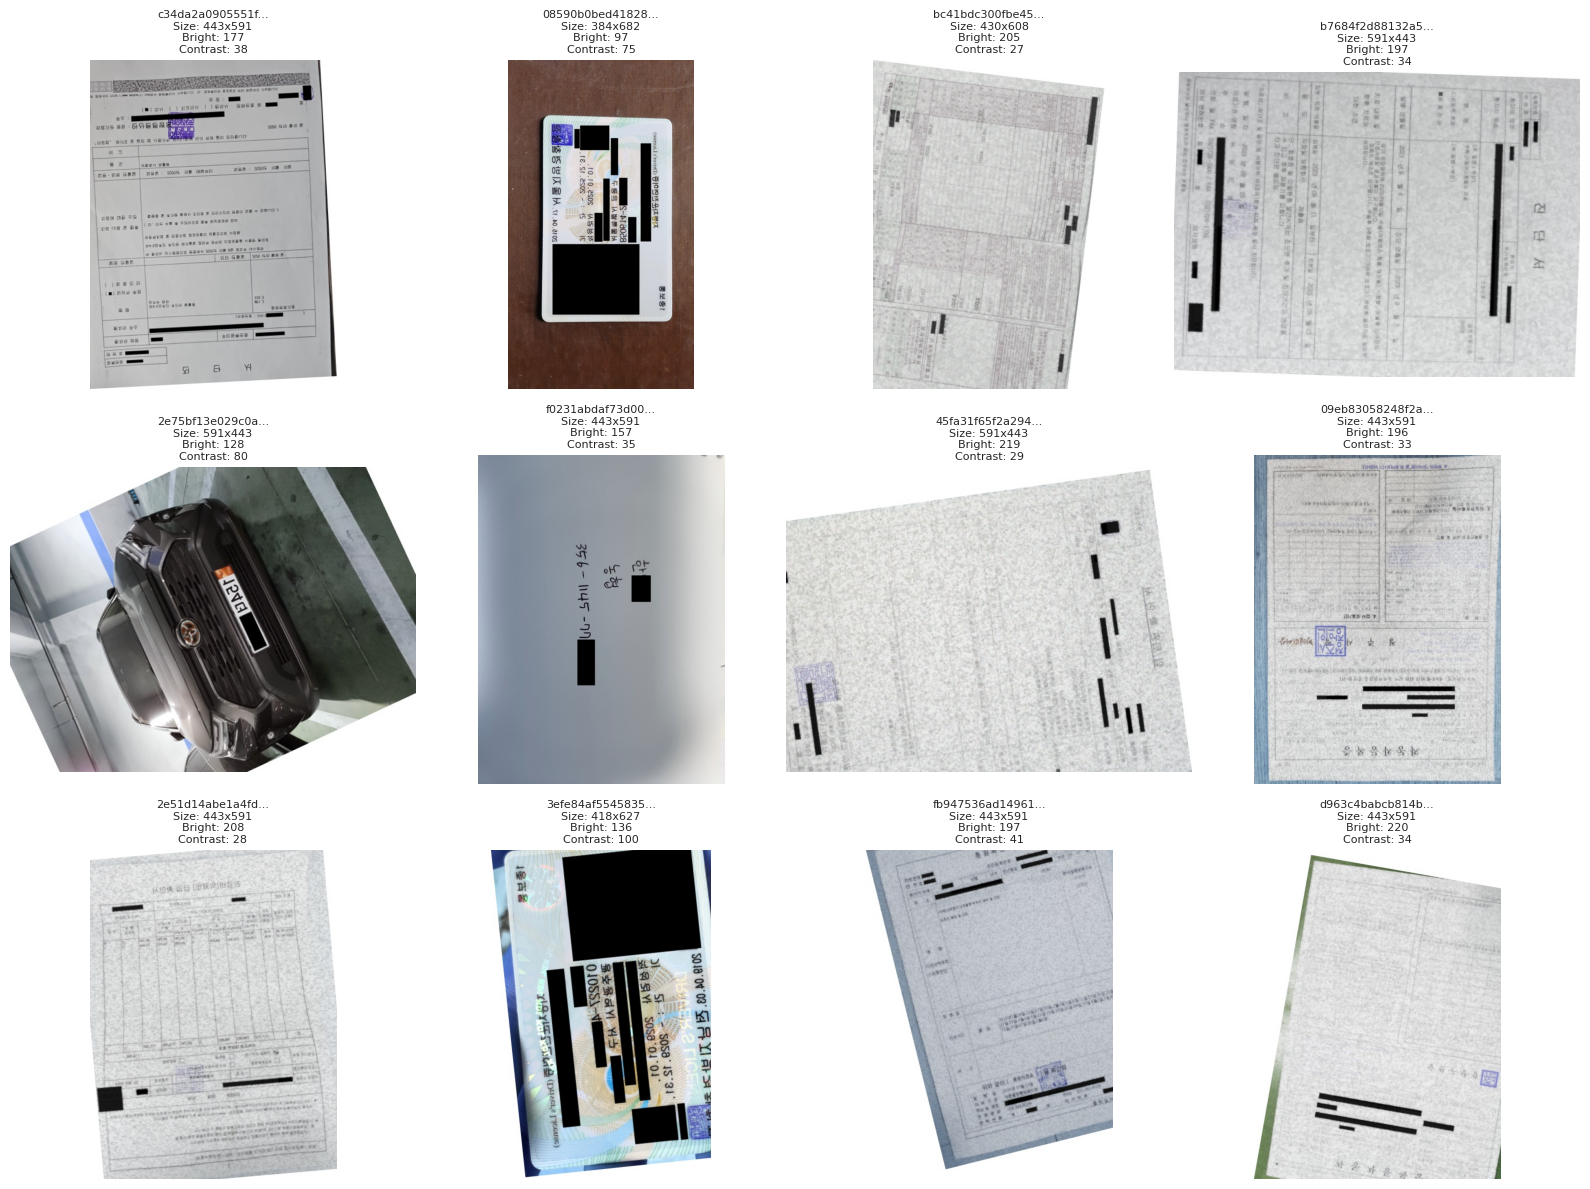


🔍 테스트 이미지 데이터 증강 분석 결과 요약
✅ 크기 조정/크롭핑: 적용됨
✅ 밝기 조정: 적용됨
✅ 대비 조정: 적용됨
✅ 색상 조정: 적용됨
✅ 회전: 적용됨
✅ 플리핑: 적용됨
✅ 블러: 적용됨
✅ 노이즈 추가: 적용됨

📊 적용된 증강 기법: 8개
📊 적용되지 않은 증강 기법: 0개

🎯 주요 적용된 증강 기법들:
   • 크기 조정/크롭핑
   • 밝기 조정
   • 대비 조정
   • 색상 조정
   • 회전
   • 플리핑
   • 블러
   • 노이즈 추가

📈 분석된 총 이미지 수: 50개
📈 테스트 폴더 전체 이미지 수: 3140개



In [19]:
# 7. 샘플 이미지 시각화 및 증강 특성 표시
def display_sample_images(num_samples=12):
    """샘플 이미지들을 시각화하고 각각의 특성을 표시합니다."""
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(sample_images))):
        if sample_images[i] is not None:
            axes[i].imshow(sample_images[i])
            axes[i].axis('off')
            
            # 이미지 특성 정보 추가
            props = df.iloc[i]
            title = f"{props['filename'][:15]}...\n"
            title += f"Size: {props['width']}x{props['height']}\n"
            title += f"Bright: {props['mean_brightness']:.0f}\n"
            title += f"Contrast: {props['contrast']:.0f}"
            
            axes[i].set_title(title, fontsize=8)
    
    # 빈 subplot 제거
    for i in range(num_samples, len(axes)):
        axes[i].remove()
    
    plt.tight_layout()
    plt.show()

display_sample_images()

# 8. 종합 분석 결과 요약
print("\n" + "="*60)
print("🔍 테스트 이미지 데이터 증강 분석 결과 요약")
print("="*60)

# 증강 기법별 결과 수집
augmentation_results = {
    '크기 조정/크롭핑': len(df[['width', 'height']].drop_duplicates()) > 1,
    '밝기 조정': (df['mean_brightness'].std() / df['mean_brightness'].mean()) > 0.15,
    '대비 조정': (df['contrast'].std() / df['contrast'].mean()) > 0.15,
    '색상 조정': False,  # 위에서 계산된 값으로 업데이트 필요
    '회전': False,  # 위에서 계산된 값으로 업데이트 필요
    '플리핑': False,  # 위에서 계산된 값으로 업데이트 필요
    '블러': False,  # 위에서 계산된 값으로 업데이트 필요
    '노이즈 추가': False  # 위에서 계산된 값으로 업데이트 필요
}

# 색상 조정 판단
red_cv = df['mean_red'].std() / df['mean_red'].mean()
green_cv = df['mean_green'].std() / df['mean_green'].mean()
blue_cv = df['mean_blue'].std() / df['mean_blue'].mean()
augmentation_results['색상 조정'] = max(red_cv, green_cv, blue_cv) > 0.15

# 기타 결과들 (이전 분석에서 구한 값들 사용)
if 'all_angles' in locals() and all_angles:
    vertical_horizontal = sum(1 for angle in all_angles if abs(angle) < 10 or abs(angle) > 80)
    diagonal = len(all_angles) - vertical_horizontal
    augmentation_results['회전'] = diagonal > vertical_horizontal * 0.3

if 'h_symmetries' in locals() and 'v_symmetries' in locals():
    augmentation_results['플리핑'] = np.std(h_symmetries) > 0.15 or np.std(v_symmetries) > 0.15

if 'laplacian_vars' in locals():
    blur_cv = np.std(laplacian_vars) / np.mean(laplacian_vars)
    augmentation_results['블러'] = blur_cv > 0.3

if 'noise_levels' in locals():
    noise_cv = np.std(noise_levels) / np.mean(noise_levels)
    augmentation_results['노이즈 추가'] = noise_cv > 0.2

# 결과 출력
applied_augmentations = []
not_applied_augmentations = []

for aug_name, is_applied in augmentation_results.items():
    if is_applied:
        applied_augmentations.append(aug_name)
        print(f"✅ {aug_name}: 적용됨")
    else:
        not_applied_augmentations.append(aug_name)
        print(f"❌ {aug_name}: 적용되지 않음")

print(f"\n📊 적용된 증강 기법: {len(applied_augmentations)}개")
print(f"📊 적용되지 않은 증강 기법: {len(not_applied_augmentations)}개")

if applied_augmentations:
    print(f"\n🎯 주요 적용된 증강 기법들:")
    for aug in applied_augmentations:
        print(f"   • {aug}")

print(f"\n📈 분석된 총 이미지 수: {len(df)}개")
print(f"📈 테스트 폴더 전체 이미지 수: {len(image_files)}개")
print("\n" + "="*60)


📁 분석 결과를 CSV 파일로 저장합니다...
✅ 이미지 분석 결과가 'image_analysis_results.csv'에 저장되었습니다.

📋 추가 분석을 위한 주요 통계:
• 이미지 크기 분포: 12 종류
• 밝기 범위: 96.8 - 220.2
• 대비 범위: 24.3 - 111.1
• 종횡비 범위: 0.563 - 1.781

🔗 특성 간 상관관계:


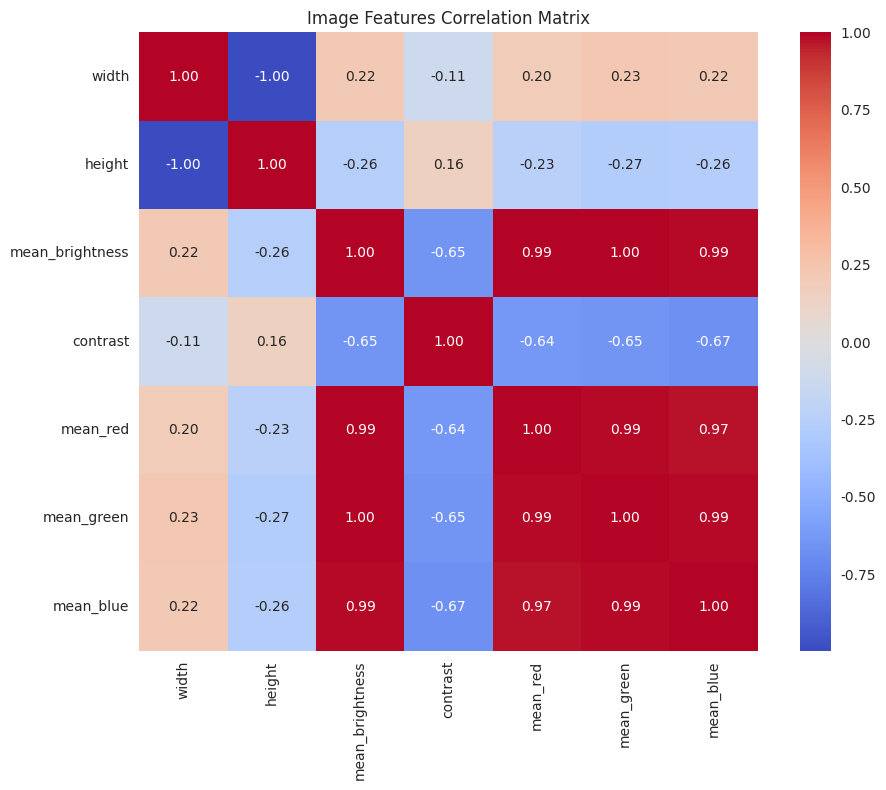


💡 추가 분석 제안:
1. 더 많은 샘플로 분석하려면 SAMPLE_SIZE를 늘려보세요.
2. 특정 클래스별로 증강을 분석하려면 train.csv와 연결해보세요.
3. 원본 이미지와 비교하려면 train 폴더의 이미지들과 비교해보세요.
4. 시간별/배치별 증강 패턴을 보려면 파일명의 패턴을 분석해보세요.
5. EXIF 데이터가 있다면 카메라 설정 정보도 분석할 수 있습니다.

🎉 분석이 완료되었습니다!


In [20]:
# 9. 분석 데이터 저장 및 추가 분석 팁
print("📁 분석 결과를 CSV 파일로 저장합니다...")

# 분석 결과를 CSV로 저장
df.to_csv('image_analysis_results.csv', index=False)
print("✅ 이미지 분석 결과가 'image_analysis_results.csv'에 저장되었습니다.")

# 추가 분석을 위한 데이터 통계
print("\n📋 추가 분석을 위한 주요 통계:")
print(f"• 이미지 크기 분포: {len(df.groupby(['width', 'height']))} 종류")
print(f"• 밝기 범위: {df['mean_brightness'].min():.1f} - {df['mean_brightness'].max():.1f}")
print(f"• 대비 범위: {df['contrast'].min():.1f} - {df['contrast'].max():.1f}")
print(f"• 종횡비 범위: {df['aspect_ratio'].min():.3f} - {df['aspect_ratio'].max():.3f}")

# 상관관계 분석
print("\n🔗 특성 간 상관관계:")
numeric_cols = ['width', 'height', 'mean_brightness', 'contrast', 'mean_red', 'mean_green', 'mean_blue']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Image Features Correlation Matrix')
plt.tight_layout()
plt.show()

# 추가 분석 제안
print("\n💡 추가 분석 제안:")
print("1. 더 많은 샘플로 분석하려면 SAMPLE_SIZE를 늘려보세요.")
print("2. 특정 클래스별로 증강을 분석하려면 train.csv와 연결해보세요.")
print("3. 원본 이미지와 비교하려면 train 폴더의 이미지들과 비교해보세요.")
print("4. 시간별/배치별 증강 패턴을 보려면 파일명의 패턴을 분석해보세요.")
print("5. EXIF 데이터가 있다면 카메라 설정 정보도 분석할 수 있습니다.")

print("\n🎉 분석이 완료되었습니다!")
